This notebook applies SPARQL query to retrieve and download biomedically relevant edge category types from Wikidata to be utilized by the downstream drug repurposing algorithm. The nodes.csv from the previous notebook is utilized here.

I. [Load Packages](#Load) [clicking on phrase will take you directly to section] <br>
II. [Identification and Filtering of Infectious Taxa as Part of Network](#Taxa) <br>
III. [Mapping Edges to Node Types](#Map)<br>
IV. [Concatenate and View Updated Node and Edge Results, Save as .csv files](#Concatenate) <br>

## Load 
Packages and modules with relevant functions

In [1]:
%matplotlib inline 
# Above line visualizes plots, cannot put note on side because of %

import pandas as pd

import time 
from datetime import datetime

import functools 
from pathlib import Path
from itertools import chain 
from tqdm.autonotebook import tqdm 

from data_tools.df_processing import char_combine_iter, add_curi
from data_tools.plotting import count_plot_h
from data_tools.wiki import execute_sparql_query, node_query_pipeline, standardize_nodes, standardize_edges

<ipython-input-1-6ef170f777f5>:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def process_taxa(edges): 
    nodes = edges.drop_duplicates(subset=['taxon', 'tax_id'])[['taxon', 'taxonLabel', 'tax_id']]
    nodes = add_curi(nodes, {'tax_id': 'NCBITaxon'})
    return standardize_nodes(nodes, 'taxon')

In [3]:
# Connects path, irrespective of OS
prev_dir = Path('../results/').resolve()
prev_nodes = pd.read_csv(prev_dir.joinpath('01a_nodes.csv')) 

In [4]:
nodes = []
edges = []

## Taxa
Account for the various taxa involved in or related to disease. This will include 2 types of syntax, and 2 approaches.

#### Syntax in the Wikidata data model

1. Direct statements:  
    Taxon has-effect Disease... or Disease has-cause Taxon 
    

2. Qualifier Statements:  
    Disease has-cause infection (qual: of Taxon) 

#### Approaches  in the Wikidata data model
1. Direct links:      
    Taxon has-effect Disease
    

2. Punning down to a specific taxonomic level:  
    Partent_taxon has-effect Disease  
    Taxon has-parent* Parent_taxon  
    Taxon has-rank Species 

In [5]:
# Create time stamp
timeStringNow = datetime.now().strftime("+%Y-%m-%dT00:00:00Z") 
start_time = time.time()

# Approach 1
## Syntax 1 -- Direct statement: Disease causes infection
q = """SELECT DISTINCT ?disease ?taxon ?taxonLabel ?tax_id
    WHERE {{?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}.
      ?disease p:P828 [ps:P828 wd:Q166231;pq:P642 ?taxon;].
      OPTIONAL{?taxon wdt:P685 ?tax_id}.
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}"""

qr = execute_sparql_query(q) # Query
tax_nodes = process_taxa(qr) # Query by taxa
edge_res = standardize_edges(qr, 'taxon', 'disease', 'causes') # Standardize taxon, disease, and causes
nodes.append(tax_nodes) # Update nodes
edges.append(edge_res) # Update edges

## Syntax 2 -- Qualifier statements
### a. disease has-cause TAXON 
q = """SELECT DISTINCT ?disease ?diseaseLabel ?doid ?taxon ?taxonLabel ?tax_id
    WHERE {{?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}.
        ?taxon wdt:P685 ?tax_id. 
       {?disease wdt:P828 ?taxon}UNION{?taxon wdt:P1542 ?disease}.
        OPTIONAL {?disease wdt:P699 ?doid.}
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}"""

qr = execute_sparql_query(q)
tax_nodes = process_taxa(qr)
edge_res = standardize_edges(qr, 'taxon', 'disease', 'causes')
nodes.append(tax_nodes)
edges.append(edge_res)

### b. TAXON has-effect Disease
q = """SELECT DISTINCT ?disease ?diseaseLabel ?doid ?taxon ?taxonLabel ?tax_id
    WHERE {{?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}.
        ?taxon wdt:P685 ?tax_id.
           {?disease wdt:P828 ?taxon}UNION{?taxon wdt:P1542 ?disease}.
           OPTIONAL {?disease wdt:P699 ?doid.}
           SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}"""

qr = execute_sparql_query(q)
tax_nodes = process_taxa(qr)
edge_res = standardize_edges(qr, 'taxon', 'disease', 'causes')
nodes.append(tax_nodes)
edges.append(edge_res)

# Approach 2 
## Syntax 1
q = """SELECT DISTINCT ?disease ?diseaseLabel ?doid ?parent_tax ?parent_taxLabel ?par_taxid ?taxon ?taxonLabel ?tax_id
    WHERE {{?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}.
      ?disease p:P828 [ps:P828 wd:Q166231;
                       pq:P642 ?parent_tax;].
      OPTIONAL{?disease wdt:P699 ?doid}.
      OPTIONAL{?parent_tax wdt:P685 ?par_taxid}.
      FILTER NOT EXISTS {?parent_tax wdt:P105 wd:Q36732}.
      FILTER NOT EXISTS {?parent_tax wdt:P105 wd:Q3978005}.
      {?taxon wdt:P171+ ?parent_tax}UNION{?parent_tax wdt:P171+ ?taxon}
      ?taxon wdt:P105 wd:Q7432 .
      ?taxon wdt:P685 ?tax_id    
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}"""

qr = execute_sparql_query(q)
tax_nodes = process_taxa(qr)
edge_res = standardize_edges(qr, 'taxon', 'disease', 'causes', 'computed')
edge_res['comp_type'] = 'punning' # What does this do? What is meant by 'punning'?
nodes.append(tax_nodes)
edges.append(edge_res)

## Syntax 2 
q = """SELECT DISTINCT ?disease ?diseaseLabel ?doid ?parent_tax ?parent_taxLabel ?parent_tax_id ?taxon ?taxonLabel ?tax_id
    WHERE 
    {{?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}.
        ?parent_tax wdt:P685 ?parent_tax_id. 
      FILTER NOT EXISTS {?parent_tax wdt:P105 wd:Q36732}.
      FILTER NOT EXISTS {?parent_tax wdt:P105 wd:Q3978005}.      
       {?disease wdt:P828 ?parent_tax}UNION{?parent_tax wdt:P1542 ?disease}.
        OPTIONAL {?disease wdt:P699 ?doid.}
      {?taxon wdt:P171+ ?parent_tax}UNION{?parent_tax wdt:P171+ ?taxon}
      ?taxon wdt:P685 ?tax_id .
      ?taxon wdt:P105 wd:Q7432 .
      SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }}
      limit 48000"""

qr = execute_sparql_query(q)
tax_nodes = process_taxa(qr)
edge_res = standardize_edges(qr, 'taxon', 'disease', 'causes', 'computed')
edge_res['comp_type'] = 'punning' 
nodes.append(tax_nodes)
edges.append(edge_res)

# Output and print when query is complete
end_time = time.time() 
print("The total time of this query is:", (end_time - start_time)/60, "minutes")

The total time of this query is: 1.1474489331245423 minutes


In [6]:
# Remove duplicates
tax_nodes = pd.concat(nodes, sort=False, ignore_index=True).drop_duplicates(subset=['id'])
nodes = [tax_nodes]

## Map
Here we use SPARQL to map node types via edges in Wikidata (ordered *almost* alphabetically) <br>
To affirm a edge type category has been added, move it to its own cell and view separately using the 'print' function.

In [7]:
# Create time stamp
timeStringNow = datetime.now().strftime("+%Y-%m-%dT00:00:00Z") 
start_time = time.time()

# IN TAXON (needs to come first for ENCODES)
## Focuses on taxa with annotations to genes or proteins in Wikidata
### Genes 
q = """SELECT DISTINCT ?taxon
    WHERE {?gene wdt:P31 wd:Q7187.
      ?gene wdt:P703 ?taxon.}"""

qr = execute_sparql_query(q)
gene_taxa = set(qr['taxon'])

q = """SELECT DISTINCT ?gene ?geneLabel ?entrez ?symbol ?hgnc ?omim ?ensembl
        WHERE {{
          ?gene wdt:P31 wd:Q7187.
          ?gene wdt:P703 wd:{tax}.
          OPTIONAL{{?gene wdt:P351 ?entrez .}}
          OPTIONAL{{?gene wdt:P353 ?symbol .}}
          OPTIONAL{{?gene wdt:P354 ?hgnc .}}
          OPTIONAL{{?gene wdt:P492 ?omim .}}
          OPTIONAL{{?gene wdt:P594 ?ensembl .}}
          SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }}}}"""

tax_gene_edges = []
gene_curi_map = {'entrez': 'NCBIGene', 'symbol': 'SYM', 'hgnc':'HGNC', 'omim':'OMIM', 'ensembl':'ENSG'}

for tax_id in gene_taxa & set(tax_nodes['id']):
    this_q = q.format(tax=tax_id)
    res = node_query_pipeline(this_q, gene_curi_map, 'gene')
    if res is None:
        continue
    nodes.append(res[['id', 'name', 'label', 'xrefs']].copy())
    res['tax'] = tax_id
    res_edges = standardize_edges(res, 'id', 'tax', 'in_taxon')
    tax_gene_edges.append(res_edges)
    
gene_tax = pd.concat(tax_gene_edges, sort=False, ignore_index=True)
edges.append(gene_tax)

q = """SELECT DISTINCT ?taxon
    WHERE {?gene wdt:P31 wd:Q7187.
      ?gene wdt:P703 ?taxon.}"""

qr = execute_sparql_query(q)
gene_taxa = set(qr['taxon'])

q = """SELECT DISTINCT ?gene ?geneLabel ?entrez ?symbol ?hgnc ?omim ?ensembl
        WHERE {{
          ?gene wdt:P31 wd:Q7187.
          ?gene wdt:P703 wd:{tax}.
          OPTIONAL{{?gene wdt:P351 ?entrez .}}
          OPTIONAL{{?gene wdt:P353 ?symbol .}}
          OPTIONAL{{?gene wdt:P354 ?hgnc .}}
          OPTIONAL{{?gene wdt:P492 ?omim .}}
          OPTIONAL{{?gene wdt:P594 ?ensembl .}}
          SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }}}}"""

tax_gene_edges = []
gene_curi_map = {'entrez': 'NCBIGene', 'symbol': 'SYM', 'hgnc':'HGNC', 'omim':'OMIM', 'ensembl':'ENSG'}

for tax_id in gene_taxa & set(tax_nodes['id']):
    this_q = q.format(tax=tax_id)
    res = node_query_pipeline(this_q, gene_curi_map, 'gene')
    if res is None:
        continue
    nodes.append(res[['id', 'name', 'label', 'xrefs']].copy())
    res['tax'] = tax_id
    res_edges = standardize_edges(res, 'id', 'tax', 'in_taxon')
    tax_gene_edges.append(res_edges)
    
gene_tax = pd.concat(tax_gene_edges, sort=False, ignore_index=True)
edges.append(gene_tax)

### Proteins
q = """SELECT DISTINCT ?taxon
    WHERE {?protein wdt:P31 wd:Q8054.
      ?protein wdt:P703 ?taxon.}"""

qr = execute_sparql_query(q)
prot_taxa = set(qr['taxon'])

q = """SELECT DISTINCT ?protein ?proteinLabel ?uniprot
        WHERE {{
          ?protein wdt:P31 wd:Q8054.
          ?protein wdt:P703 wd:{tax}.
          OPTIONAL{{?protein wdt:P352 ?uniprot .}}
          SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }}}}"""

tax_prot_edges = []

for tax_id in prot_taxa & set(tax_nodes['id']):
    this_q = q.format(tax=tax_id)
    res = node_query_pipeline(this_q, {'uniprot':'UniProt'}, 'protein')
    if res is None:
        continue
    nodes.append(res[['id', 'name', 'label', 'xrefs']].copy())
    res['tax'] = tax_id
    res_edges = standardize_edges(res, 'id', 'tax', 'in_taxon')
    tax_prot_edges.append(res_edges)
    
prot_tax = pd.concat(tax_prot_edges, sort=False, ignore_index=True)
edges.append(prot_tax)

# ASSOCIATED WITH
## Gene ASSOCIATED WITH Disease
q = """SELECT DISTINCT ?disease ?diseaseLabel ?gene ?geneLabel 
WHERE {{?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}.
    ?gene wdt:P31 wd:Q7187 .
    ?disease wdt:P2293 ?gene
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }}"""

qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'gene', 'disease', 'associated_with')
edges.append(edge_res)

## Pathway ASSOCIATED WITH Disease
q = """SELECT DISTINCT ?pathway ?disease 
WHERE {
    ?pathway wdt:P31 wd:Q4915012 .
    FILTER NOT EXISTS{?pathway wdt:P686 ?goid}
    {?disease wdt:P31 wd:Q12136 .}UNION{?disease wdt:P699 ?doid}
    {?pathway wdt:P1050 ?disease}}"""

qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'pathway', 'disease', 'associated_with')
edges.append(edge_res)

# ENABLES
## Protein ENABLES Molecular Function
q = """SELECT DISTINCT ?protein ?molecular_function
WHERE {?protein wdt:P31 wd:Q8054.
  ?molecular_function wdt:P686 ?goid.
  {?protein wdt:P680 ?molecular_function}}"""

qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'protein', 'molecular_function', 'enables')
edges.append(edge_res)

# ENCODES
## Gene ENCODES Protein (note focus on Homo sapiens)
q = """SELECT DISTINCT ?gene ?protein 
WHERE {{
  ?gene wdt:P31 wd:Q7187.
  ?gene wdt:P703 wd:{tax}.
  ?protein wdt:P31 wd:Q8054.
  ?protein wdt:P703 wd:{tax}.
  {{?gene wdt:P688 ?protein}}UNION{{?protein wdt:P702 ?gene}}}}"""

human_tax_id = 'Q15978631'
encodes_edges = []
infectious_tax = list(set(gene_tax['end_id']) & set(prot_tax['end_id']))

for tax in infectious_tax + [human_tax_id]:
    this_q = q.format(tax=tax)
    qr = execute_sparql_query(this_q)
    if qr is not None:
        this_edge = standardize_edges(qr, 'gene', 'protein', 'encodes')
        encodes_edges.append(this_edge)
        
encodes_edges = pd.concat(encodes_edges, sort=False, ignore_index=True)
edges.append(encodes_edges) 

# HAS PART
## Pathway HAS PART Compoound
q = """SELECT DISTINCT ?pathway ?compound 
WHERE {
    ?pathway wdt:P31 wd:Q4915012 .
    FILTER NOT EXISTS{?pathway wdt:P686 ?goid}
    ?compound wdt:P31 wd:Q11173 .
    ?pathway wdt:P527 ?compound}"""

qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'pathway', 'compound', 'has_part')
edges.append(edge_res)

## Pathway HAS PART Gene
q = """SELECT DISTINCT ?pathway ?gene 
WHERE {?pathway wdt:P31 wd:Q4915012 .
    FILTER NOT EXISTS{?pathway wdt:P686 ?goid}
    ?gene wdt:P31 wd:Q7187 .
    ?pathway wdt:P527 ?gene}"""

qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'pathway', 'gene', 'has_part')
edges.append(edge_res)

# INVOLVED IN
## Pathway INVOLVED IN Biological Process
q = """SELECT DISTINCT ?pathway ?bio_process 
WHERE {
    ?pathway wdt:P31 wd:Q4915012 .
    FILTER NOT EXISTS{?pathway wdt:P686 ?goid}
    ?bio_process wdt:P31 wd:Q2996394 .
    ?bio_process wdt:P686 ?goid .
    {?pathway wdt:P31 ?bio_process}UNION{?bio_process wdt:P31 ?pathway}}"""

qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'pathway', 'bio_process', 'involved_in')
edges.append(edge_res)

## Protein INVOLVED IN Biological Process
q = """SELECT DISTINCT ?protein ?biological_process
WHERE {?protein wdt:P31 wd:Q8054.
  ?biological_process wdt:P686 ?goid.
  {?protein wdt:P682 ?biological_process}}"""

qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'protein', 'biological_process', 'involved_in')
edges.append(edge_res)

# INTERACTS WITH
## Compound INTERACTS WITH Protein
q = """SELECT DISTINCT ?compound ?compoundLabel ?qualifier ?qualifierLabel ?protein ?proteinLabel 
WHERE {
    ?compound wdt:P31 wd:Q11173 .
    ?protein wdt:P31 wd:Q8054 .
    { ?compound p:P129 [ps:P129 ?protein;
                  pq:P2868 ?qualifier] }
    UNION { ?protein p:P129 [ps:P129 ?compound;
                 pq:P366 ?qualifier] }
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }}"""

qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'compound', 'protein', 'qualifierLabel')
edges.append(edge_res)

# PART OF
## Protein PART OF Cellular Component
q = """SELECT DISTINCT ?protein ?cell_component
WHERE {?protein wdt:P31 wd:Q8054.
  ?cell_component wdt:P686 ?goid.
  {?protein wdt:P681 ?cell_component}}"""

qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'protein', 'cell_component', 'part_of')
edges.append(edge_res)

# SITE OF
## Anatomy SITE OF Disease
q = """SELECT DISTINCT ?disease ?diseaseLabel ?anatomy ?anatomyLabel 
WHERE {
    {?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}.
    {?disease1 wdt:P31 wd:Q12136}UNION{?disease1 wdt:P699 ?doid1}.
    ?anatomy wdt:P1554 ?uberon .
    {?disease1 wdt:P927 ?anatomy} {?disease wdt:P279? ?disease1}
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }}"""

qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'anatomy', 'disease', 'site_of')
edges.append(edge_res)

# ? Presents ? is this an edge..?
## Disease to Phenotype

q = """SELECT DISTINCT ?disease ?pheno
  WHERE {{?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}
      {?pheno wdt:P31 wd:Q169872.}UNION{?pheno wdt:P3841 ?hpo}
      {?pheno wdt:P780 ?disease}UNION{?disease wdt:P780 ?pheno}}"""

qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'disease', 'pheno', 'presents')
edges.append(edge_res)

# ?? SUBCLASS OF ?? What is the purpose of this 'later punning' meaning...?
## Anatomy SUBCLASS OF Anatomy
q = """SELECT DISTINCT ?anatomy ?anatomyLabel ?anatomy1 ?anatomy1Label
WHERE {
    ?anatomy wdt:P1554 ?uberon .
    ?anatomy1 wdt:P1554 ?uberon1 .
    ?anatomy wdt:P279? ?anatomy1
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }}"""

qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'anatomy', 'anatomy1', 'subclass_of')
edges.append(edge_res)

## Disease SUBCLASS OF Disease
q = """SELECT DISTINCT ?disease ?diseaseLabel ?disease1 ?disease1Label
WHERE {{?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}.
    {?disease1 wdt:P31 wd:Q12136}UNION{?disease1 wdt:P699 ?doid1}.
    ?disease wdt:P279? ?disease1
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }}"""

qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'disease', 'disease1', 'subclass_of')
edges.append(edge_res)

# TREATS
## Compound TREATS Disease
q = """SELECT DISTINCT ?compound ?compoundLabel ?disease ?diseaseLabel
  WHERE {
    ?compound wdt:P31 wd:Q11173 .
    {?disease wdt:P31 wd:Q12136}UNION{?disease wdt:P699 ?doid}.
    {?compound wdt:P2175 ?disease}UNION{?disease wdt:P2176 ?compound}
    SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }}"""

qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'compound', 'disease', 'treats')
edges.append(edge_res)

## Compound TREATS Phenotype
q = """SELECT DISTINCT ?compound ?pheno
  WHERE {?compound wdt:P31 wd:Q11173 .
      {?pheno wdt:P31 wd:Q169872.}UNION{?pheno wdt:P3841 ?hpo}
      {?pheno wdt:P2176 ?compound}UNION{?compound wdt:P2175 ?pheno}}"""

qr = execute_sparql_query(q)
edge_res = standardize_edges(qr, 'compound', 'pheno', 'treats')
edges.append(edge_res)

# Output and print when query is complete
end_time = time.time() 
print("The total time of this query is:", (end_time - start_time)/60, "minutes")

The total time of this query is: 7.847133616606395 minutes


## Concatenate
Affirm queries and compile into a csv (2 total)

In [8]:
nodes.append(prev_nodes)
nodes = pd.concat(nodes, sort=False, ignore_index=True)
edges = pd.concat(edges, sort=False, ignore_index=True)

In [9]:
len(nodes) # 808915 (previously 1074047 with 150,000 Compound limit)

808915

In [10]:
nodes['id'].nunique() # 590093

590093

In [11]:
nodes.head()

,id,name,label,xrefs
0,Q1010102,Bunyaviridae,Taxon,
1,Q1026758,Caliciviridae,Taxon,NCBITaxon:11974
2,Q10457821,Conidiobolus coronatus,Taxon,NCBITaxon:34488
3,Q10462705,Cryptostroma corticale,Taxon,NCBITaxon:1463975
4,Q10584816,Microsporum distortum,Taxon,NCBITaxon:101202


<AxesSubplot:xlabel='label'>

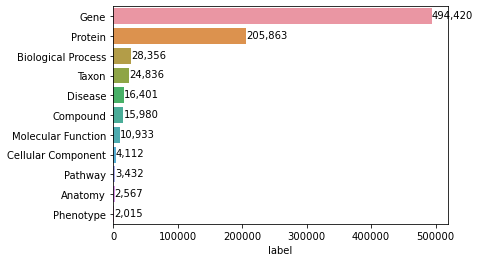

In [12]:
count_plot_h(nodes['label']) # Graph form of value counts from nodes file

In [13]:
len(edges) # 4024308 (edges go down by about 100000 with new limit) 

4024308

In [14]:
edges['start_id'].append(edges['end_id']).nunique() # 919005 (where the row is unique for both columns) right?

919005

In [15]:
edges.head() # comp_type NaN??? (check for 'punning')

,start_id,end_id,type,dsrc_type,comp_type
0,Q570260,Q19000458,causes,crowd_sourced,NaN
1,Q7435269,Q55009424,causes,crowd_sourced,NaN
2,Q2368907,Q19001357,causes,crowd_sourced,NaN
3,Q1648694,Q19000740,causes,crowd_sourced,NaN
4,Q1437858,Q55009396,causes,crowd_sourced,NaN


<AxesSubplot:xlabel='type'>

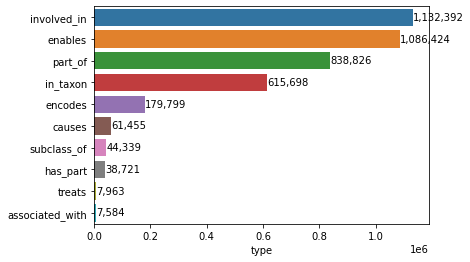

In [16]:
count_plot_h(edges['type'].value_counts().head(10)) # note there are more after this if you remove .head(10)

In [17]:
out_dir = Path('../results/')

out_dir.mkdir(parents=True, exist_ok=True)

nodes.to_csv(out_dir.joinpath('01b_nodes.csv'), index=False)
edges.to_csv(out_dir.joinpath('01b_edges.csv'), index=False)